In [4]:
import pandas as pd
import numpy as np
import datetime
import requests
from requests.auth import HTTPBasicAuth
import tarfile
import os
import shutil
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

#keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Conv2D, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model,Sequential 
from tensorflow.keras import optimizers, regularizers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [5]:
def get_organize_files(): 
    #download files with images
    #https://talhassner.github.io/home/projects/Adience/Adience-data.html
    print('starting download')
    BASE_URL = "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification"
    DOWNLOAD_FILES = {
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz": "aligned.tar.gz",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_0_data.txt": "fold_0_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_1_data.txt": "fold_1_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_2_data.txt": "fold_2_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_3_data.txt": "fold_3_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_4_data.txt": "fold_4_data.txt"
                    }

    for DOWNLOAD_FILE, FILE_NAME in DOWNLOAD_FILES.items():
        if not os.path.exists(FILE_NAME):
            with open(FILE_NAME, 'wb') as file:
                r = requests.get(DOWNLOAD_FILE, auth = HTTPBasicAuth('adiencedb', 'adience'))
                file.write(r.content)
                print('downloaded {}'.format(FILE_NAME))
    
    print('unziping images...')
    
    if not os.path.exists('aligned'):
        with tarfile.open('aligned.tar.gz') as file:
            file.extractall()
        
    print('images unziped')
    
    #compile all files catalog
    fold = pd.read_csv('fold_0_data.txt',sep='\t')
    fold.rename(columns={'user_id':'user_id'},inplace=True)
    fold['fold'] = 0
    for i in range(1,5):
        temp = pd.read_csv('fold_'+str(i)+'_data.txt',sep='\t')
        temp['fold'] = i
        fold = fold.append(temp,ignore_index=True)

    fold.dropna(subset=['gender'],inplace=True)
    fold = fold[['user_id','original_image','face_id','age','gender','fold']]
     
    train = fold.groupby('gender',as_index=False,group_keys=False).apply(lambda x: x.sample(frac=.7))
    test = fold.drop(train.index).groupby('gender',as_index=False,group_keys=False).apply(lambda x: x.sample(frac=.5))
    validation = fold.drop(train.index).drop(test.index)
    
    print('Train and test split done')
    
    #creates directories for training, test and validation files
    cwd = os.getcwd()
    
    train_faces = os.path.join(cwd,'train')
    if not os.path.exists(train_faces):
        os.mkdir(train_faces)

    test_faces = os.path.join(cwd,'test')
    if not os.path.exists(test_faces):
        os.mkdir(test_faces)
    
    validation_faces = os.path.join(cwd,'validation')
    if not os.path.exists(validation_faces):
        os.mkdir(validation_faces)

    #copy images to each directory
    for index, row in train.iterrows():
        src = os.path.join(cwd,'aligned',row['user_id'],'landmark_aligned_face.'+str(row['face_id'])+'.'+row['original_image'])
        dst = os.path.join(train_faces,row['original_image'])
        shutil.copyfile(src,dst)

    print('train images copied')

    for index, row in test.iterrows():
        src = os.path.join(cwd,'aligned',row['user_id'],'landmark_aligned_face.'+str(row['face_id'])+'.'+row['original_image'])
        dst = os.path.join(test_faces,row['original_image'])
        shutil.copyfile(src,dst)
        
    for index, row in validation.iterrows():
        src = os.path.join(cwd,'aligned',row['user_id'],'landmark_aligned_face.'+str(row['face_id'])+'.'+row['original_image'])
        dst = os.path.join(validation_faces,row['original_image'])
        shutil.copyfile(src,dst)

    print('train images copied')

    print('test images copied')
    
    print('validation images copied')
    
    return cwd,fold,train_faces,test_faces,validation_faces,train,test,validation


In [6]:
cwd,fold,train_faces,test_faces,validation_faces,train_images_ids,test_images_ids,validation_images_ids = get_organize_files()

starting download
downloaded fold_0_data.txt
downloaded fold_1_data.txt
downloaded fold_2_data.txt
downloaded fold_3_data.txt
downloaded fold_4_data.txt
unziping images...
images unziped
Train and test split done
train images copied
train images copied
test images copied
validation images copied


In [7]:
def Model_gender_mx():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3, 3)))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3, 3))) 
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3, 3))) 
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
    
    return model

In [8]:
#vectorizing images 
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
                    train_images_ids,
                    x_col='original_image',
                    y_col='gender',
                    directory=train_faces,
                    target_size=(150,150),
                    batch_size=100,
                    class_mode='categorical',
                   # rotation_range = 40,
                   # width_shift_range = 0.2,
                   # height_shift_range = 0.2,
                   # shear_range = 0.2,
                   # zoom_range = 0.2,
                   # horizontal_flip = True,
                   # fill_mode = 'nearest'
                    ) 


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                    validation_images_ids,
                    x_col='original_image',
                    y_col='gender',
                    directory=validation_faces,
                    target_size=(150,150),
                    batch_size=100,
                    class_mode='categorical',
                    )

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
                    test_images_ids,
                    x_col='original_image',
                    y_col='gender',
                    directory=test_faces,
                    target_size=(150,150),
                    batch_size=100,
                    class_mode='categorical',
                    )

Found 13013 validated image filenames belonging to 3 classes.
Found 2789 validated image filenames belonging to 3 classes.
Found 2789 validated image filenames belonging to 3 classes.


In [9]:
checkpoint = ModelCheckpoint("best_model_mx.hdf5", monitor='val_acc', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [10]:
#training model
model = Model_gender_mx()
history = model.fit_generator(train_generator,
                              steps_per_epoch=130,
                              epochs=30,
                              validation_data = validation_generator,
                              validation_steps=27,
                              callbacks=[checkpoint])
model.save('face_gender_detection.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

<ipython-input-10-2fee13cf7a6d>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
130/130 [==============================] - ETA: 0s - loss: 0.8759 - acc: 0.5134
Epoch 1: val_acc improved from -inf to 0.50519, saving model to best_model_mx.hdf5
130/130 [==============================] - 273s 2s/step - loss: 0.8759 - acc: 0.5134 - val_loss: 0.9507 - val_acc: 0.5052
Epoch 2/30
130/130 [==============================] - ETA: 0s - loss: 0.8373 - acc: 0.5342
Epoch 2: val_acc improved from 0.50519 to 0.53444, saving model to best_model_mx.hdf5
130/130 [==============================] - 325s 2s/step - loss: 0.8373 - acc: 0.5342 - val_loss: 0.8805 - val_acc: 0.5344
Epoch 3/30
130/130 [==============================] - ETA: 0s - loss: 0.8129 - acc: 0.5541
Epoch 3: val_acc did not improve from 0.53444
130/130 [==============================] - 327s 3s/step - loss: 0.8129 - acc: 0.5541 - val_loss: 0.8407 - val_acc: 0.5226
Epoch 4/30
130/130 [==============================] - ETA: 0s - loss: 0.7884 - acc: 0.5751
Epoch 4: val_acc improved from 0.53444 to 0.63630, savi

130/130 [==============================] - ETA: 0s - loss: 0.5495 - acc: 0.7362
Epoch 30: val_acc improved from 0.79519 to 0.79741, saving model to best_model_mx.hdf5
130/130 [==============================] - 171s 1s/step - loss: 0.5495 - acc: 0.7362 - val_loss: 0.5533 - val_acc: 0.7974


<ipython-input-11-8f47c2426443>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, (2789  / 100)) # ceil(num_of_test_samples / batch_size)


              precision    recall  f1-score   support

         Men       0.50      0.49      0.50      1406
       Woman       0.41      0.42      0.42      1218
        Baby       0.08      0.07      0.08       165

    accuracy                           0.44      2789
   macro avg       0.33      0.33      0.33      2789
weighted avg       0.44      0.44      0.44      2789



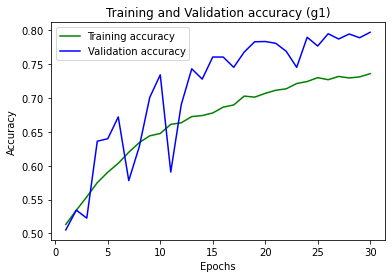

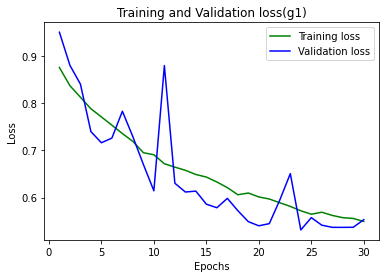

In [11]:
Y_pred = model.predict_generator(validation_generator, (2789  / 100)) # ceil(num_of_test_samples / batch_size)
target_names = ['Men', 'Woman','Baby']
print(classification_report(validation_generator.classes[:Y_pred.shape[0]],
                            list(np.argmax(Y_pred,axis=1)), 
                            target_names=target_names))


acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(1,31)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy (g1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss(g1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()